In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [ ]:
# schema here: https://docs.nvidia.com/nsight-systems/2024.6/UserGuide/index.html#sqlite-schema-reference
cnx = sqlite3.connect("jax_gpu.prof.sqlite") #connected to database with out error

In [111]:
QUERY_MAX_MIN_TIMES = """
    WITH all_times AS (
        SELECT
            MIN(start) AS start,
            MAX(end) AS end
        FROM CUPTI_ACTIVITY_KIND_KERNEL
        UNION
        SELECT
            MIN(start) AS start,
            MAX(end) AS end
        FROM OSRT_API
    )
    SELECT
        MIN(start) AS min_time,
        MAX(end) AS max_time
    FROM all_times
"""

QUERY_STRING_IDS = """
    SELECT
        id,
        value
    FROM StringIds
"""

QUERY_CUPTI_ACTIVITY_KIND_KERNEL = """
    SELECT
        start,
        end
    FROM CUPTI_ACTIVITY_KIND_KERNEL
"""

QUERY_OSRT_APIT = """
    SELECT
        start,
        end,
        callchainId
    FROM OSRT_API
"""

QUERY_OSRT_CALLCHAINS = """
    SELECT
        id,
        symbol,
        module
    FROM OSRT_CALLCHAINS
"""

In [ ]:
def compute_normalized_counts(
    data:pd.DataFrame,
    times:np.ndarray,
) -> np.ndarray:
    """Compute the normalized counts for the given times and data."""
    counts = [(data['start'] <= t) & (data['end'] > t) for t in times]
    totals = [np.sum(c) for c in counts]
    mx = np.max(totals)
    normalized_totals = [t / mx for t in totals]
    return np.array(normalized_totals)


def get_gpu_utilization(times:np.ndarray, connection:sqlite3.Connection) -> np.ndarray:
    """Get the GPU utilization for the given times from the database."""
    # CUPTI_ACTIVITY_KIND_KERNEL is the table that contains kernel execution times
    cupti_activity_kind_kernel = pd.read_sql_query(QUERY_CUPTI_ACTIVITY_KIND_KERNEL, connection)
    return compute_normalized_counts(cupti_activity_kind_kernel, times)


def get_cpu_utilization(times:np.ndarray, connection:sqlite3.Connection) -> np.ndarray:
    """Get the CPU utilization for the given times from the database."""
    # StringIds contains common string used in the database
    string_ids = pd.read_sql_query("SELECT id, value FROM StringIds", connection)

    osrt_callchains = (
        pd.read_sql_query(QUERY_OSRT_CALLCHAINS, cnx)
        # replace the integer ids for symbol with the string value and drop the unneeded columns
        .join(string_ids, on="symbol", how="left", rsuffix="_symbol")
        .drop(columns=["id_symbol", "symbol"])
        .rename(columns={"value":"symbol"})
        # replace the integer ids for module with the string value and drop the unneeded columns
        .join(string_ids, on="module", how="left", rsuffix="_module")
        .drop(columns=["id_module", "module"])
        .rename(columns={"value":"module"})
    )
    is_python_callchaing = osrt_callchains["module"].str.contains("python")
    python_callchain_ids = osrt_callchains.loc[is_python_callchaing, "id"].unique()

    osrt_api = (
        pd.read_sql_query(QUERY_OSRT_APIT, connection)
        .join(osrt_callchains, on="callchainId", how="left")
    )
    orst_api_python = (
        osrt_api
        .loc[osrt_api["callchainId"].isin(python_callchain_ids)]
        .sort_values(by="start", inplace=False)
    )

    return compute_normalized_counts(orst_api_python, times)


def get_times(n_times:int, connection:sqlite3.Connection) -> np.ndarray:
    """Get the start and end times from the database."""
    min_time, max_time = pd.read_sql_query(QUERY_MAX_MIN_TIMES, connection).values[0]
    return np.linspace(min_time, max_time, n_times)


In [123]:
times = get_times(1000, cnx)

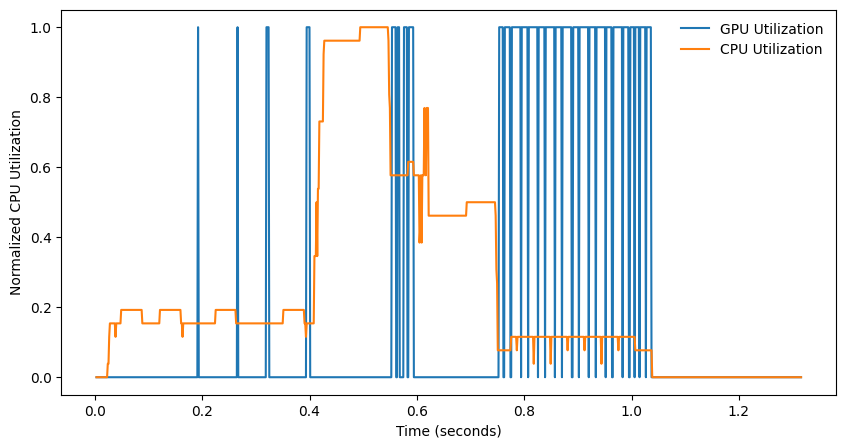

In [140]:
gpu_utilization = get_gpu_utilization(times, cnx)
cpu_utilization = get_cpu_utilization(times, cnx)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times/1e9, gpu_utilization, label="GPU Utilization")
ax.plot(times/1e9, cpu_utilization, label="CPU Utilization")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Normalized CPU Utilization")
ax.legend(frameon=False)

In [ ]:
q = """
WITH memory_events AS (
    -- Get memory copy events with their sizes and timestamps
    SELECT
        start,
        end,
        deviceId,
        bytes,
        copyKind,
        srcKind,
        dstKind,
        CASE
            WHEN copyKind IN (1, 2) THEN bytes  -- Host to Device or Device to Host
            WHEN copyKind = 3 THEN bytes        -- Device to Device
            ELSE 0
        END as gpu_memory_delta
    FROM CUPTI_ACTIVITY_KIND_MEMCPY
    WHERE bytes > 0
),

kernel_memory AS (
    -- Get kernel executions with their memory usage
    SELECT
        start,
        end,
        deviceId,
        (staticSharedMemory + dynamicSharedMemory) as shared_memory,
        localMemoryTotal,
        demangledName
    FROM CUPTI_ACTIVITY_KIND_KERNEL
),

gpu_info AS (
    -- Get GPU device information including total memory
    SELECT
        id as deviceId,
        name as gpu_name,
        totalMemory,
        l2CacheSize,
        constantMemory
    FROM TARGET_INFO_GPU
)

-- Main query: Calculate memory usage over time
SELECT
    me.start as timestamp,
    me.deviceId,
    gi.gpu_name,
    gi.totalMemory as total_gpu_memory_bytes,
    me.bytes as transfer_bytes,
    me.copyKind,
    mem_kind_src.label as source_memory_type,
    mem_kind_dst.label as destination_memory_type,
    -- Running sum of memory transfers to estimate GPU memory usage
    SUM(CASE
        WHEN me.copyKind = 1 THEN me.bytes  -- Host to Device (allocation)
        WHEN me.copyKind = 2 THEN -me.bytes -- Device to Host (potential deallocation)
        ELSE 0
    END) OVER (
        PARTITION BY me.deviceId
        ORDER BY me.start
        ROWS UNBOUNDED PRECEDING
    ) as estimated_gpu_memory_usage_bytes,
    -- Calculate percentage of total GPU memory
    (SUM(CASE
        WHEN me.copyKind = 1 THEN me.bytes
        WHEN me.copyKind = 2 THEN -me.bytes
        ELSE 0
    END) OVER (
        PARTITION BY me.deviceId
        ORDER BY me.start
        ROWS UNBOUNDED PRECEDING
    ) * 100.0 / gi.totalMemory) as gpu_memory_usage_percentage

FROM memory_events me
JOIN gpu_info gi ON me.deviceId = gi.deviceId
LEFT JOIN ENUM_CUDA_MEM_KIND mem_kind_src ON me.srcKind = mem_kind_src.id
LEFT JOIN ENUM_CUDA_MEM_KIND mem_kind_dst ON me.dstKind = mem_kind_dst.id
ORDER BY me.deviceId, me.start;
"""

data = pd.read_sql_query(q, cnx)

,timestamp,deviceId,gpu_name,total_gpu_memory_bytes,transfer_bytes,copyKind,source_memory_type,destination_memory_type,estimated_gpu_memory_usage_bytes,gpu_memory_usage_percentage
0,25752703,0,Tesla V100-PCIE-32GB,34072559616,2,1,Pinned,Device,2,5.869826e-09
1,25922974,0,Tesla V100-PCIE-32GB,34072559616,2,8,Device,Device,2,5.869826e-09
2,163305295,0,Tesla V100-PCIE-32GB,34072559616,4,1,Pinned,Device,6,1.760948e-08
3,203292289,0,Tesla V100-PCIE-32GB,34072559616,343932928,8,Device,Device,6,1.760948e-08
4,267267166,0,Tesla V100-PCIE-32GB,34072559616,6798544,1,Pageable,Device,6798550,1.995315e-02
5,268140119,0,Tesla V100-PCIE-32GB,34072559616,8,1,Pageable,Device,6798558,1.995318e-02
6,268547348,0,Tesla V100-PCIE-32GB,34072559616,8,1,Pageable,Device,6798566,1.995320e-02
7,330483296,0,Tesla V100-PCIE-32GB,34072559616,688537600,8,Device,Device,6798566,1.995320e-02
8,393164038,0,Tesla V100-PCIE-32GB,34072559616,343932928,8,Device,Device,6798566,1.995320e-02
9,400199569,0,Tesla V100-PCIE-32GB,34072559616,688537600,8,Device,Device,6798566,1.995320e-02


In [ ]:
GPU_UTILIZATION_FROM_python_ids = osrt_callchains_w_fnames.loc[osrt_callchains_w_fnames["module"].str.contains("python"), "id"].unique()METRICS = pd.read_sql_query(
"""
WITH gpu_timeline AS (
  SELECT
    deviceId,
    start as timestamp,
    'start' as event_type
  FROM CUPTI_ACTIVITY_KIND_KERNEL
  UNION ALL
  SELECT
    deviceId,
    end as timestamp,
    'end' as event_type
  FROM CUPTI_ACTIVITY_KIND_KERNEL
),
gpu_busy_periods AS (
  SELECT
    deviceId,
    timestamp,
    SUM(CASE WHEN event_type = 'start' THEN 1 ELSE -1 END)
      OVER (PARTITION BY deviceId ORDER BY timestamp) as active_kernels
  FROM gpu_timeline
)
SELECT
  deviceId,
  timestamp,
  CASE WHEN active_kernels > 0 THEN 1 ELSE 0 END as is_busy
FROM gpu_busy_periods
ORDER BY deviceId, timestamp;
""",
    cnx
)

In [100]:
GPU_UTILIZATION_FROM_METRICS

,deviceId,timestamp,is_busy
0,0,90354199,1
1,0,90942930,0
2,0,191288124,1
3,0,192615794,0
4,0,264829744,1
...,...,...,...
313,0,1032741541,0
314,0,1032742533,1
315,0,1034494936,0
316,0,1034495896,1


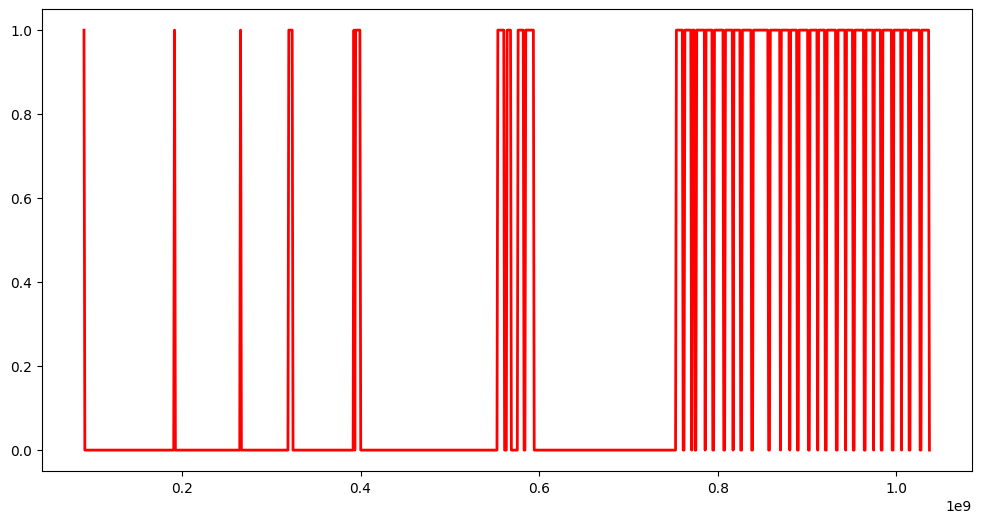

In [107]:
cupti_activity_kind_kernel =  pd.read_sql_query("""SELECT * FROM CUPTI_ACTIVITY_KIND_KERNEL""", cnx)


mn, max = cupti_activity_kind_kernel["start"].min(), cupti_activity_kind_kernel["end"].max()
times = np.linspace(mn, max, 1000)
counts = [(cupti_activity_kind_kernel['start'] <= t) & (cupti_activity_kind_kernel['end'] > t) for t in times]
totals = [np.sum(c) for c in counts]
normalized_totals = [t / np.max(totals) for t in totals]

f, ax = plt.subplots(figsize=(12, 6))
ax.plot(times, normalized_totals, color='red', label='GPU Utilization', linewidth=2)

<BarContainer object of 500 artists>

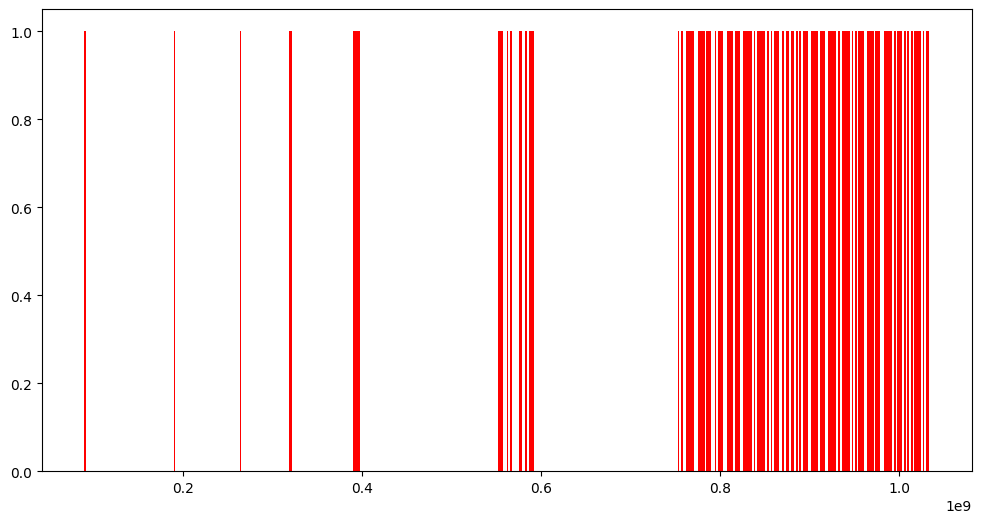

In [ ]:
GPU_UTILIZATION_FROM_METRICS
f, ax = plt.subplots(figsize=(12, 6))

hist, bins = np.histogram(
    GPU_UTILIZATION_FROM_METRICS.loc[GPU_UTILIZATION_FROM_METRICS["is_busy"]==1, ["timestamp"]].values,
    bins=500
)

ax.bar(bins[:-1], np.minimum(hist, 1), width=np.diff(bins), color='red', label='Python Callchains Histogram')

In [7]:
osrt_api = pd.read_sql_query("""SELECT * FROM OSRT_API""", cnx)
osrt_callchains = pd.read_sql_query("""SELECT * FROM OSRT_CALLCHAINS""", cnx)
string_ids = pd.read_sql_query("""SELECT * FROM StringIds""", cnx)
enum_nsys_event_classes = pd.read_sql_query("""SELECT * FROM ENUM_NSYS_EVENT_CLASS""", cnx)

In [ ]:
# need to set the index to the id column for merging using .join()
enum_nsys_event_classes.index = enum_nsys_event_classes['id']
enum_nsys_event_classes

,id,name,label
id,,,
0,0,TRACE_PROCESS_EVENT_CUDA_RUNTIME,CUDA runtime
1,1,TRACE_PROCESS_EVENT_CUDA_DRIVER,CUDA driver
2,2,TRACE_PROCESS_EVENT_GL,GL
3,3,TRACE_PROCESS_EVENT_TSP_OVERHEAD,TSP overhead
4,4,TRACE_PROCESS_EVENT_GL_DEBUG,GL debug
...,...,...,...
96,96,TRACE_PROCESS_EVENT_CUDA_GRAPH_CLONE,CUDA graph clone
107,107,TRACE_PROCESS_EVENT_SYSCALL,Syscall
108,108,TRACE_PROCESS_EVENT_TEGRA_INTERNAL,Tegra Internal API


In [46]:
osrt_w_fnames = (
    osrt_api
    .join(string_ids, on="nameId", how="left")
    .drop(columns=["id", "nameId"])
    .rename(columns={"value": "function_name"})
    .join(enum_nsys_event_classes, on="eventClass", how="left", rsuffix="_ec")
    .drop(columns=["eventClass", "id"])
    .rename(columns={"name": "eventClass", "label": "eventClassLabel"})
)

osrt_w_fnames["duration"] = osrt_w_fnames["end"] - osrt_w_fnames["start"]

In [ ]:
osrt_callchains_w_fnames = (
    osrt_callchains
    .join(string_ids, on="symbol", how="left", rsuffix="_symbol")
    .drop(columns=["id_symbol", "symbol"])
    .rename(columns={"value":"symbol"})
    .join(string_ids, on="module", how="left", rsuffix="_module")
    .drop(columns=["id_module", "module"])
    .rename(columns={"value":"module"})
)

In [70]:
osrt_callchains_w_fnames

,id,kernelMode,thumbCode,unresolved,specialEntry,originalIP,unwindMethod,stackDepth,symbol,module
0,1,0,0,0,None,138023386330592,None,0,pthread_cond_wait@@GLIBC_2,/usr/lib/x86_64-linux-gnu/libc.so.6
1,1,0,0,0,None,138023262720071,None,1,std::condition_variable::wait(std::unique_lock...,/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.33
2,1,0,0,0,None,138016252858475,None,2,llvm::StdThreadPool::processTasks(llvm::Thread...,/home/ryan/miniforge3/envs/flfm-pytorch/lib/py...
3,1,0,0,0,None,138016252863477,None,3,void* llvm::thread::ThreadProxy<std::tuple<llv...,/home/ryan/miniforge3/envs/flfm-pytorch/lib/py...
4,1,0,0,1,None,138023395135901,None,4,0x7d881370119d,/opt/nvidia/nsight-systems/2024.6.2/target-lin...
...,...,...,...,...,...,...,...,...,...,...
4311,440,0,0,0,None,138016252858475,None,2,llvm::StdThreadPool::processTasks(llvm::Thread...,/home/ryan/miniforge3/envs/flfm-pytorch/lib/py...
4312,440,0,0,0,None,138016252863477,None,3,void* llvm::thread::ThreadProxy<std::tuple<llv...,/home/ryan/miniforge3/envs/flfm-pytorch/lib/py...
4313,440,0,0,1,None,138023395135901,None,4,0x7d881370119d,/opt/nvidia/nsight-systems/2024.6.2/target-lin...
4314,440,0,0,0,None,138023386335908,None,5,start_thread,/usr/lib/x86_64-linux-gnu/libc.so.6


In [82]:
python_ids = osrt_callchains_w_fnames.loc[osrt_callchains_w_fnames["module"].str.contains("python"), "id"].unique()
python_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29, 103, 104, 105, 106, 107, 108, 109, 110, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 280, 281, 282, 283, 284,
       285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 29

In [76]:
osrt_w_fnames[osrt_w_fnames["callchainId"].isin(python_ids)]

,start,end,globalTid,returnValue,nestingLevel,callchainId,function_name,eventClass,eventClassLabel,duration
0,613032086,613654931,286171372734087,0,0.0,1,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,622845
1,613887523,614475597,286171372734087,0,0.0,2,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,588074
9,614906918,615153649,286171372734087,0,0.0,3,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,246731
19,615536854,615815941,286171372734087,0,0.0,4,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,279087
20,615819436,616122252,286171372734087,0,0.0,5,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,302816
...,...,...,...,...,...,...,...,...,...,...
2307,420710894,420816642,286171372734063,0,0.0,436,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,105748
2308,420830522,421124313,286171372734063,0,0.0,437,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,293791
2310,421237661,421335912,286171372734063,0,0.0,438,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,98251
2311,421348114,421546677,286171372734063,0,0.0,439,pthread_cond_wait,TRACE_PROCESS_EVENT_OS_RUNTIME,OSRT runtime,198563


In [84]:
osrt_w_fnames["callchainId"].isin(python_ids) & (osrt_w_fnames["globalTid"]==286171372734087)

0        True
1        True
2       False
3       False
4       False
        ...  
2345    False
2346    False
2347    False
2348    False
2349    False
Length: 2350, dtype: bool

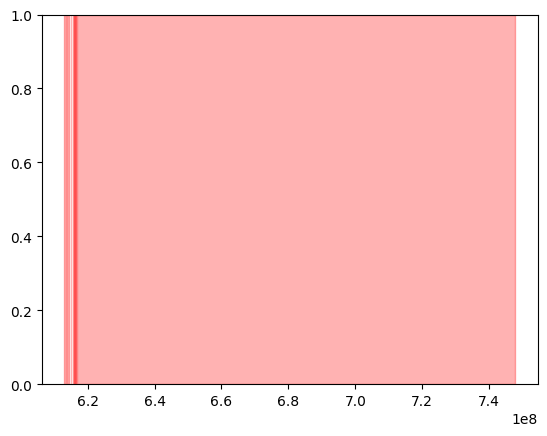

In [88]:
filtered_osrt_w_fnames = (
    osrt_w_fnames
    .loc[osrt_w_fnames["callchainId"].isin(python_ids) & (osrt_w_fnames["globalTid"]==286171372734087)]
    .copy()
    .sort_values(by="start", inplace=False)
)

start_vals = filtered_osrt_w_fnames["start"].values
end_vals = filtered_osrt_w_fnames["end"].values

for s, e in zip(start_vals, end_vals):
    plt.axvspan(s, e, color='red', alpha=0.3)




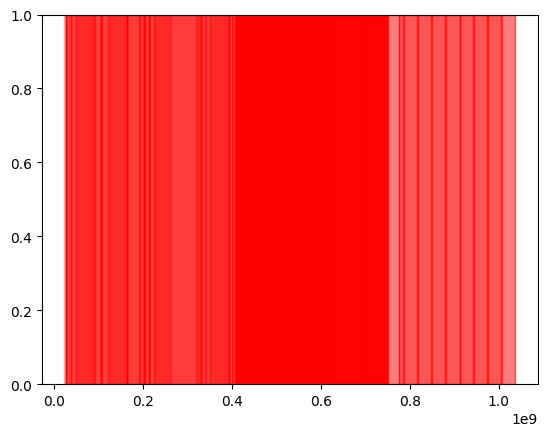

In [ ]:
filtered_osrt_w_fnames = (
    osrt_w_fnames
    .loc[osrt_w_fnames["callchainId"].isin(python_ids)]
    .copy()
    .sort_values(by="start", inplace=False)
)

start_vals = filtered_osrt_w_fnames["start"].values
end_vals = filtered_osrt_w_fnames["end"].values

for s, e in zip(start_vals, end_vals):
    plt.axvspan(s, e, color='red', alpha=0.3)


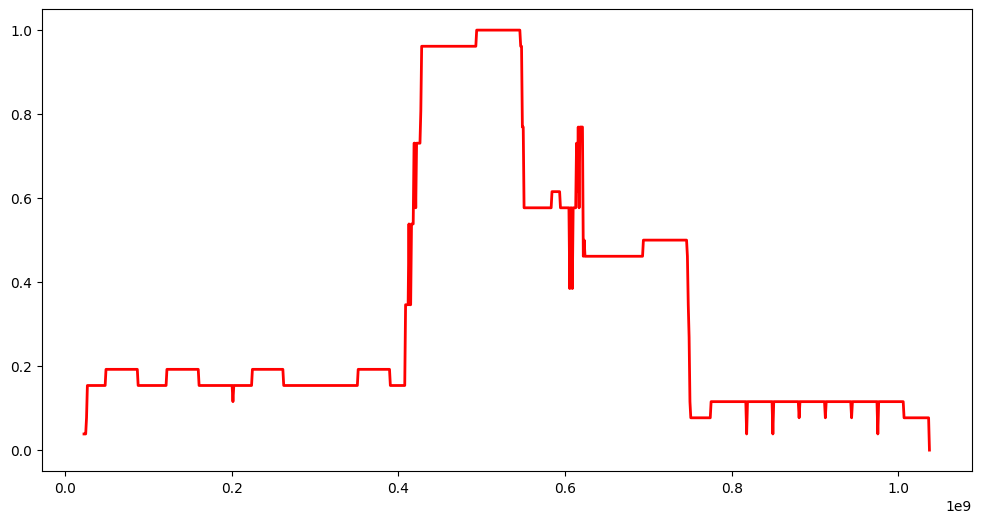

In [105]:
filtered_osrt_w_fnames = (
    osrt_w_fnames
    .loc[osrt_w_fnames["callchainId"].isin(python_ids)]
    .copy()
    .sort_values(by="start", inplace=False)
)

mn, max = filtered_osrt_w_fnames["start"].min(), filtered_osrt_w_fnames["end"].max()
times = np.linspace(mn, max, 1000)
counts = [(filtered_osrt_w_fnames['start'] <= t) & (filtered_osrt_w_fnames['end'] > t) for t in times]
totals = [np.sum(c) for c in counts]
normalized_totals = [t / np.max(totals) for t in totals]

f, ax = plt.subplots(figsize=(12, 6))
ax.plot(times, normalized_totals, color='red', label='Python Callchains Count', linewidth=2)


<BarContainer object of 500 artists>

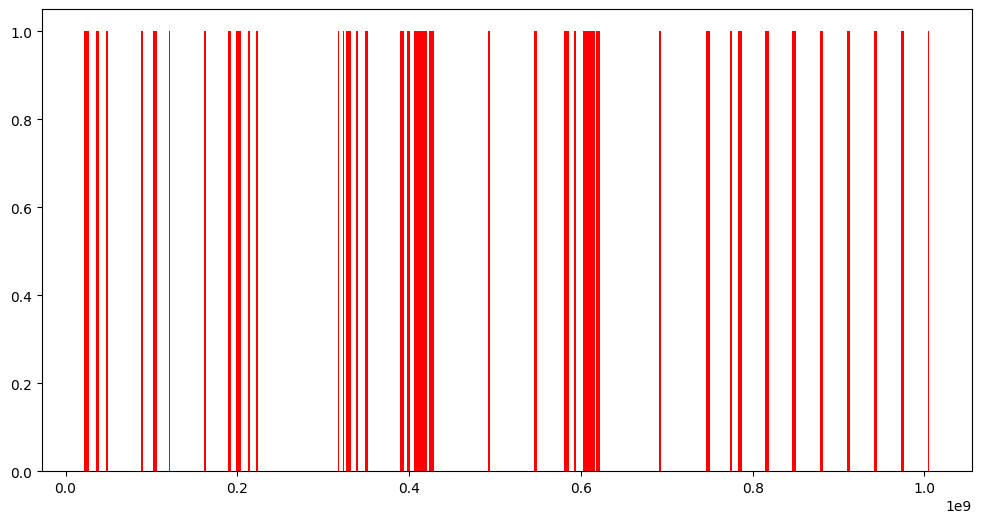

In [99]:
filtered_osrt_w_fnames = (
    osrt_w_fnames
    .loc[osrt_w_fnames["callchainId"].isin(python_ids)]
    .copy()
    .sort_values(by="start", inplace=False)
)

hist, bins = np.histogram(filtered_osrt_w_fnames["start"].values, bins=500)
# plt.scatter(start_vals, np.ones_like(start_vals), color='red', alpha=0.3, label='Python Callchains')

f, ax = plt.subplots(figsize=(12, 6))
ax.bar(bins[:-1], np.minimum(hist, 1), width=np.diff(bins), color='red', label='Python Callchains Histogram')